# Analysis of Region and Product Change-Points

This notebook first creates region and product sub-networks. For region sub-networks, it removes any nodes outside of the region and its direct trade partners. For the product sub-networks it changes the edge weights to only the trade values for a given group of products (based on the highest level of SITC codes). Then, the best trained S-GNN is applied to each of these sub-networks and the resulting change-points can be analyzed.

In [1]:
import sys
sys.path.append('/Users/sinclaireschuetze/Documents/GitHub/Trade-GNN-Thesis/src')
import pandas as pd
import numpy as np
import pickle as pkl
import datetime as datetime
import torch
from model import GraphSAGE, SiameseGNN
from utils.CreateFeatures import CreateFeatures
from utils.functions import dist_labels_to_changepoint_labels
from torch_geometric.utils import k_hop_subgraph

## Region Networks

In [ ]:
with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
    all_graphs = pkl.load(f)
    
countries = ['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB',
       'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA',
       'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FSM',
       'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA',
       'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU',
       'LUX', 'LVA', 'MAC', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL',
       'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT',
       'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR',
       'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW',
       'PNG', 'POL', 'PRT', 'PRY', 'PSE', 'PYF', 'QAT', 'ROU', 'RUS',
       'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SMR',
       'SRB', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SXM',
       'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON',
       'TTO', 'TUN', 'TUR', 'TUV', 'TZA', 'UGA', 'UKR', 'URY', 'USA',
       'UZB', 'VCT', 'VEN', 'VNM', 'VUT', 'WSM', 'YEM', 'ZAF', 'ZMB',
       'ZWE']

In [ ]:
def load_model(model_path: str):
    """
    Loads trained model and encoder
    """

    encoder = GraphSAGE(27, 16, 0.1)
    encoder.load_state_dict(torch.load(f'{model_path}-encoder.pt'))
    model = SiameseGNN(encoder, 50, 27, dropout = 0.05, nhidden=16)
    model.load_state_dict(torch.load(f'{model_path}.pt'))

    return model

In [7]:
model = load_model('../saved-models/sage-gdp-mis_norm')
model.eval()

SiameseGNN(
  (encoder): GraphSAGE(
    (conv1): SAGEConv(27, 32, aggr=mean)
    (conv2): SAGEConv(32, 16, aggr=mean)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (similarity): PairwiseDistance()
  (fc1): Linear(in_features=50, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
#Get region (continent) for each country
country_codes = pd.read_excel("../data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]

locations = pd.read_stata("../data/location_classifications/location.dta")
locations['location_id'] = locations['location_id'].astype(int)
locations.drop(columns = ['location_id','location_name_short_en','level'], inplace = True)

df_with_regions = country_codes.merge(locations, left_on = "location_code", right_on = "location_code")
df_nodes = df_with_regions[df_with_regions['location_code'].isin(countries)] 
columns_to_keep = ["English short name","location_code","parent_id"]
df_columns = df_nodes[columns_to_keep]
df_columns.reset_index(drop=True, inplace=True)

In [17]:
#Creates dictionaries of countries in each region and node indices in each region
countries_by_region = {}
indices_by_region = {}
for i in countries:
    region = int(df_columns[df_columns['location_code']==i]['parent_id'].iloc[0])
    if region != 358: #region 358 is Antarctica, don't need to include that
        if region not in countries_by_region:
            countries_by_region[region] = [i]
        else:
            countries_by_region[region].append(i)

        #Gets node index of each country to be able to properly remove from network
        index = countries.index(i)
        index_np = np.int32(index)
        if region not in indices_by_region:
            indices_by_region[region] = [index_np]
        else:
            indices_by_region[region].append(index_np)

indices_by_region[352] = indices_by_region[352][:-2]
regions = list(countries_by_region.keys())

In [18]:
#Loads graphs and mis-norm feature dict
with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
    all_graphs = pkl.load(f)

with open("../feature_dicts/mis_norm.pkl", "rb") as f:
    feat_dict = pkl.load(f)

In [19]:
def add_features(years, graphs, feat_dict, dim):
    """
    For each row in x tensor of network, adds additional node features

    Returns set of graphs for all years
    """

    zeros = torch.zeros(dim)

    for i in range(len(years)):
        new_x = torch.empty(0, dim)
        year = years[i]
        
        feat_dict_year = feat_dict[year].combined_features

        for j, country in enumerate(countries):
            if j == 0:
                new_x = torch.stack([zeros])

            elif country in feat_dict_year["country_code"].values:
                tensor_before = graphs[i].x[j]
                country_row = feat_dict_year[feat_dict_year["country_code"] == country]
                country_row = country_row.drop(columns = ["country_code", "current_gdp_growth"])
                row_values = country_row.values.tolist()
                row_tensor = torch.tensor(row_values)[0]
                combined_values = torch.cat((tensor_before, row_tensor))

                new_x = torch.cat((new_x, combined_values.unsqueeze(0)), dim=0)

            else:
                new_x = torch.cat((new_x, zeros.unsqueeze(0)), dim=0)

        graphs[i].x = new_x

    return graphs

In [22]:
#Creates dictionary with graphs by region where only the nodes within a region and their direct neighbors are kept
years = range(1962,2019)
sub_graphs_by_region = {}
regions = list(countries_by_region.keys())
for r in regions:
    with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
        all_graphs = pkl.load(f)
        all_graphs = add_features(years, all_graphs, feat_dict, 27)
    sub_graphs_by_region[r] = []
    for i in range(57):
        example_edge_index = all_graphs[i].edge_index
        edge_index = example_edge_index.to(torch.int32)
        ex_nodes = indices_by_region[r]
            
        subset, new_edge_index, mapping, edge_mask = k_hop_subgraph(node_idx=ex_nodes, num_hops = 1, edge_index=edge_index)
        temp_graph = all_graphs[i]
        temp_graph.edge_index = new_edge_index
        sub_graphs_by_region[r].append(temp_graph)

In [23]:
crisis_years = [1973, 1991, 1995, 2000, 2007, 2016, 2018]
phases = []
p = -1
for i in range(1962,2019):
    if i in crisis_years:
        p += 1
    phases.append(p)

cp_times = [t-1962 for t in crisis_years]
labels = dist_labels_to_changepoint_labels(phases)

In [38]:
import json
with open(f'../data/region-graphs/region-353/graphs.p', 'wb') as f:
    pkl.dump(sub_graphs_by_region[353], f)

with open(f'../data/region-graphs/region-353/labels.p', 'wb') as f:
    pkl.dump(labels, f)

with open(f'../data/region-graphs/region-353/cp-times.json', 'w') as f:
    json.dump(cp_times, f)

In [39]:
change_points = {}
similarity_scores_norm_gdp = {}

for r in [353, 356]:
    with open(f"../data/region-graphs/region-{r}/avg_similarity.p", 'rb') as file:
        avg_sim = pkl.load(file)
        similarity_scores_norm_gdp[r] = avg_sim

    with open(f"../data/region-graphs/region-{r}/est_cps.p", 'rb') as file:
        cps = pkl.load(file)
        adj = [i+1962 for i in cps]
        change_points[r] = adj

FileNotFoundError: [Errno 2] No such file or directory: '../data/region-graphs/region-353/avg_similarity.p'

In [30]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

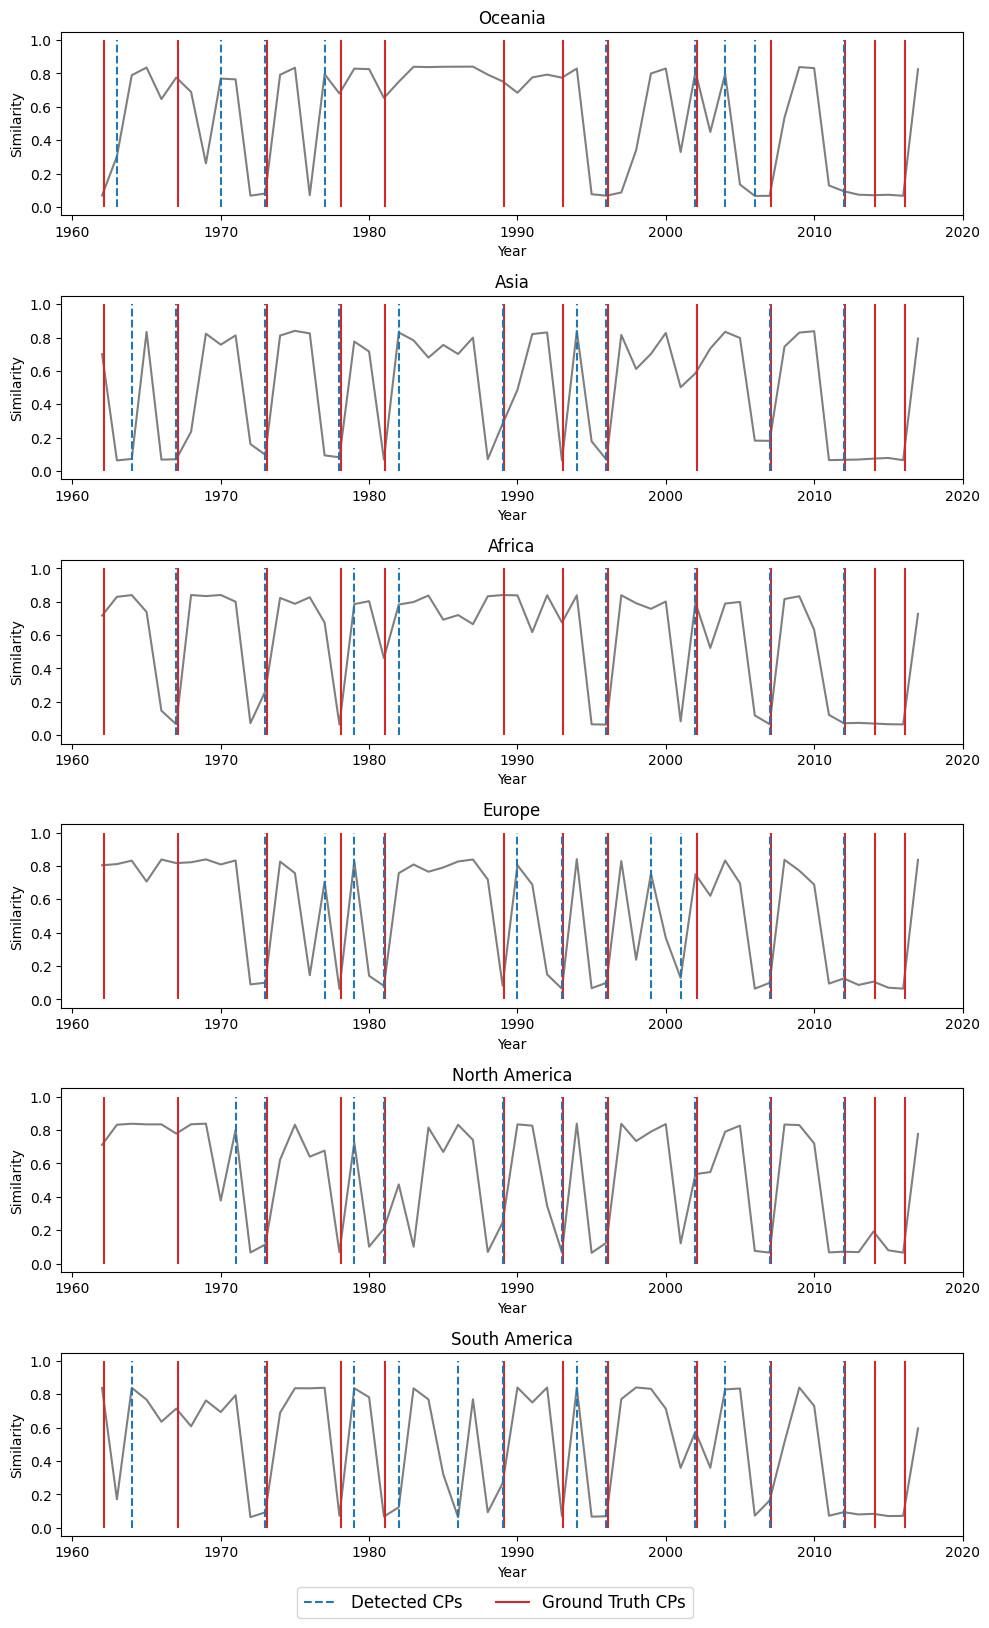

In [ ]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(6,8))
times = range(1962,2018)
selected_times = crisis_years

regions = [354, 353, 352, 355, 356, 357]
for j,i in enumerate(regions):
    # Plot just one line, for example, the LAD line
    axs[j].plot(times, similarity_scores_norm_gdp[i], label=f'Region {region_mappings[i]}', color='tab:grey')
    adjusted_cps = [i+0.1 for i in selected_times]

    axs[j].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
    axs[j].vlines(x=change_points[i], ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')

    axs[j].grid(visible=False)
    axs[j].set_xlabel(rf'Year')
    axs[j].set_ylabel(rf'Similarity')
    axs[j].set_title(f'{region_mappings[i]}')

    axs[j].set_xticks(range(1960, 2021, 10))

    handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
               mlines.Line2D([], [], color='tab:red', linestyle='-', label='Ground Truth CPs')]

# Add the legend to the figure
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize='large')

plt.tight_layout()
plt.show()

## Product Networks

In [72]:
with open("src/pygcn/graphs_nogdp.pkl", "rb") as f:         
    all_graphs = pkl.load(f)

In [297]:
with open("graphs/product_graphs/product_9.pkl", "rb") as f:         
    product_graphs = pkl.load(f)

In [243]:
with open("feature_dicts/mis_norm.pkl", "rb") as f:
    feat_dict = pkl.load(f)

In [180]:
def add_features(years, graphs, feat_dict, dim):

    zeros = torch.zeros(dim)

    for i in range(len(years)):
        new_x = torch.empty(0, dim)
        year = years[i]

        feat_dict_year = feat_dict[year].combined_features

        for j, country in enumerate(countries):
            if j == 0:
                new_x = torch.stack([zeros])

            elif country in feat_dict_year["country_code"].values:
                tensor_before = graphs[i].x[j]
                country_row = feat_dict_year[feat_dict_year["country_code"] == country]
                country_row = country_row.drop(columns = ["country_code", "current_gdp_growth"])
                row_values = country_row.values.tolist()
                row_tensor = torch.tensor(row_values)[0]
                combined_values = torch.cat((tensor_before, row_tensor))

                new_x = torch.cat((new_x, combined_values.unsqueeze(0)), dim=0)

            else:
                new_x = torch.cat((new_x, zeros.unsqueeze(0)), dim=0)

        graphs[i].x = new_x

    return graphs

In [298]:
years = range(1962,2019)
all_graphs = add_features(years, all_graphs, feat_dict, 27)

In [299]:
for j,i in enumerate(all_graphs):
    i.edge_index = product_graphs[j].edge_index
    i.edge_attr = product_graphs[j].edge_attr

In [300]:
crisis_years = [1962, 1967, 1973, 1978, 1981, 1989, 1993, 1996, 2002, 2007, 2012, 2014, 2016]
phases = []
p = -1
for i in range(1962,2019):
    if i in crisis_years:
        p += 1
    phases.append(p)

cp_times = [t-1962 for t in crisis_years]
labels = dist_labels_to_changepoint_labels(phases)

In [301]:
import json
with open(f'results/product_graphs/mis_norm_gdp/product-9-graphs.p', 'wb') as f:
    pkl.dump(all_graphs, f)

with open(f'results/product_graphs/mis_norm_gdp/product-9-labels.p', 'wb') as f:
    pkl.dump(labels, f)

with open(f'results/product_graphs/mis_norm_gdp/cp-times.json', 'w') as f:
    json.dump(cp_times, f)

In [149]:
change_points = {}
similarity_scores_product_norm_no_gdp = {}
for i in range(10):
    with open(f"results/product_results/mis_norm_no_gdp/product_{i}/avg_similarity.p", 'rb') as file:
        avg_sim = pkl.load(file)
        similarity_scores_product_norm_no_gdp[i] = avg_sim

    with open(f"results/product_results/mis_norm_no_gdp/product_{i}/est_cps.p", 'rb') as file:
        cps = pkl.load(file)
        adj = [c+1962 for c in cps]
        change_points[i] = adj

In [150]:
product_cat = {0: "Food And Live Animals", 
               1:"Beverages And Tobacco", 
               2: "Crude Materials, Inedible, Except Fuels", 
               3: "Mineral Fuels, Lubric. And Related Mtrls", 
               4: "Animal And Vegetable Oils, Fats And Waxes", 
               5: "Chemicals And Related Products", 
               6: "Manufactured Goods Classif. By Material", 
               7: "Machinery And Transport Equipment", 
               8: "Miscellaneous Manufactured Articles", 
               9: "Goods Not Classif. Elsewhere In The Sitc"}

In [151]:
raw_products = [2, 3, 4, 5]
manufactured_products = [0, 1, 6, 7, 8, 9]

raw_product_sim_scores = []
manufactured_product_sim_scores = []

for i in product_cat.keys():
    if i in raw_products:
        raw_product_sim_scores.append(similarity_scores_product_norm_no_gdp[i])
    else:
        manufactured_product_sim_scores.append(similarity_scores_product_norm_no_gdp[i])

In [152]:
raw_prod_averages = np.mean(raw_product_sim_scores, axis=0)
manu_prod_averages = np.mean(manufactured_product_sim_scores, axis=0)

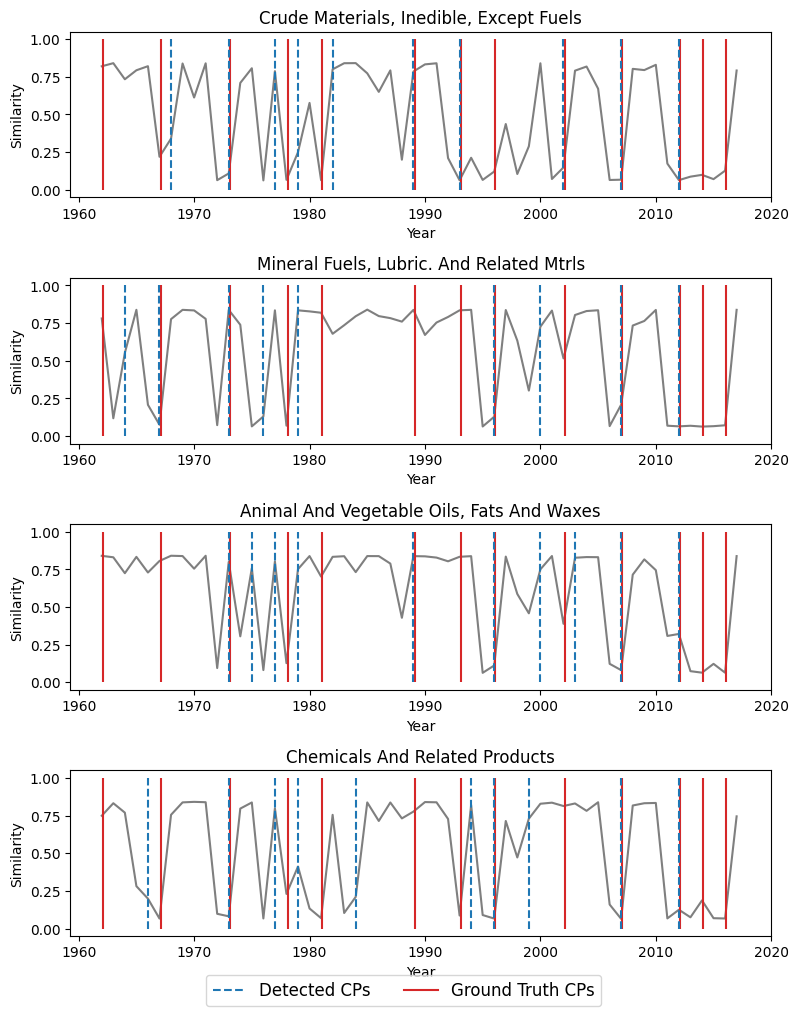

In [155]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(8,10))
times = range(1962,2018)
selected_times = crisis_years

for j,i in enumerate([2, 3, 4, 5]):
    # Plot just one line, for example, the LAD line
    axs[j].plot(times, similarity_scores_product_norm_no_gdp[i], label=f'{product_cat[i]}', color='tab:grey')
    adjusted_cps = [i+0.1 for i in selected_times]

    axs[j].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
    axs[j].vlines(x=change_points[i], ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')

    axs[j].grid(visible=False)
    axs[j].set_xlabel(rf'Year')
    axs[j].set_ylabel(rf'Similarity')
    axs[j].set_title(f'{product_cat[i]}')

    handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
               mlines.Line2D([], [], color='tab:red', linestyle='-', label='Ground Truth CPs')]
    
    axs[j].set_xticks(range(1960, 2021, 10))

# Add the legend to the figure
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize='large')

plt.tight_layout()
plt.show()

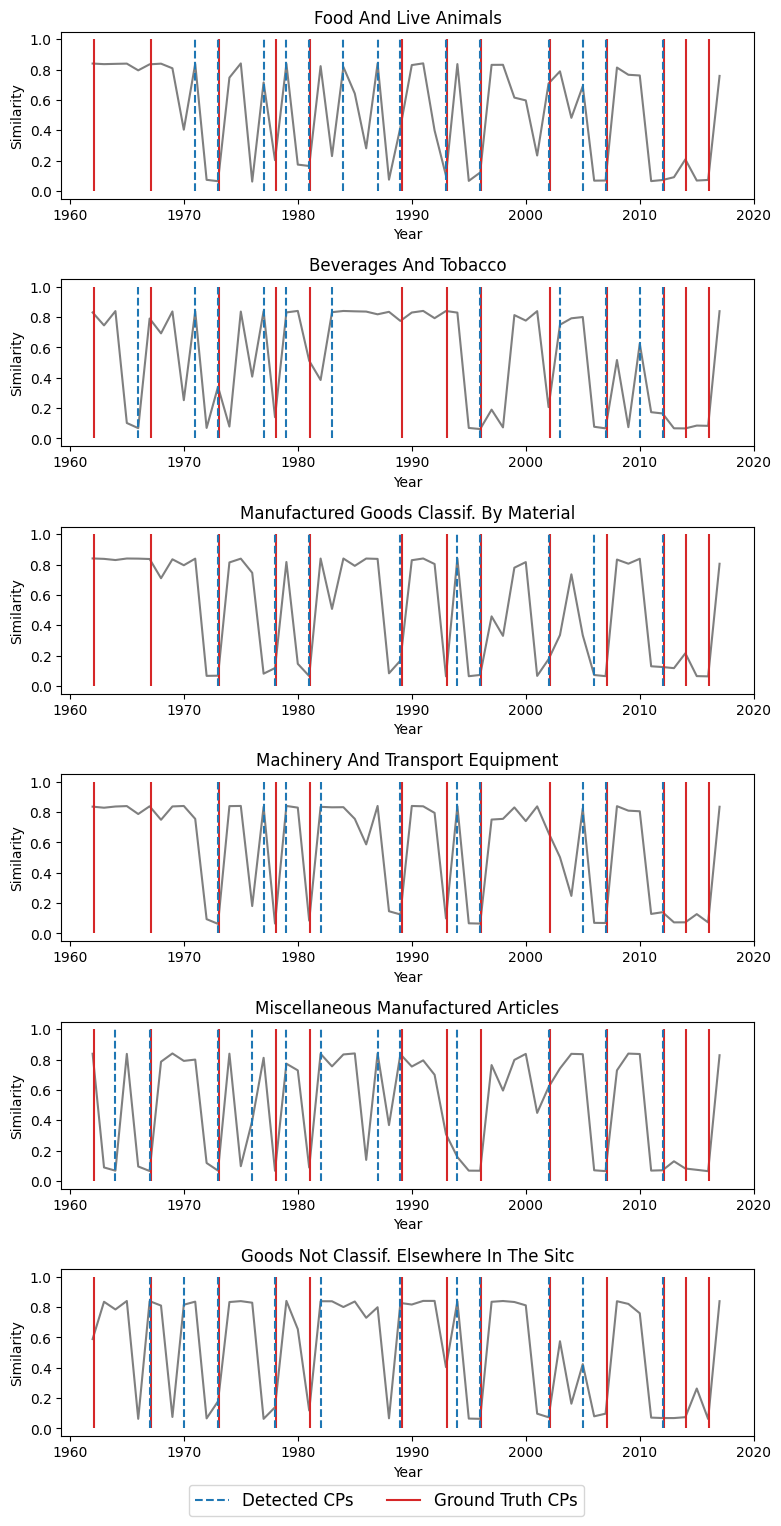

In [157]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(8,15))
times = range(1962,2018)
selected_times = crisis_years

for j,i in enumerate([0, 1, 6, 7, 8, 9]):
    # Plot just one line, for example, the LAD line
    axs[j].plot(times, similarity_scores_product_norm_no_gdp[i], label=f'{product_cat[i]}', color='tab:grey')
    adjusted_cps = [i+0.1 for i in selected_times]

    axs[j].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
    axs[j].vlines(x=change_points[i], ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')

    axs[j].grid(visible=False)
    axs[j].set_xlabel(rf'Year')
    axs[j].set_ylabel(rf'Similarity')
    axs[j].set_title(f'{product_cat[i]}')

    handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
               mlines.Line2D([], [], color='tab:red', linestyle='-', label='Ground Truth CPs')]
    
    axs[j].set_xticks(range(1960, 2021, 10))

# Add the legend to the figure
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize='large')

plt.tight_layout()
plt.show()

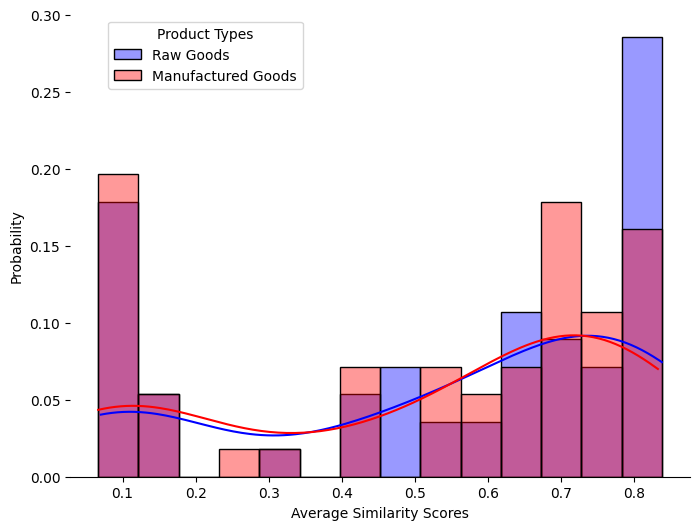

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create some sample data
data1 = raw_prod_averages
data2 = manu_prod_averages

# Create the plot
plt.figure(figsize=(8,6))
bins = np.linspace(min(min(data1), min(data2)), max(max(data1), max(data2)), 15)

# Create the first histogram
sns.histplot(data1, bins=bins, alpha=0.4, label='Raw Goods', color = "blue", kde=True, stat='probability')

# Create the second histogram
sns.histplot(data2, bins=bins, alpha=0.4, label='Manufactured Goods', color = "red", kde=True, stat='probability')

plt.ylabel("Probability")
plt.xlabel("Average Similarity Scores")

# Add a legend
plt.legend(loc='upper left', title='Product Types', bbox_to_anchor=(0.05, 1))

# Remove right, left, and top spines
sns.despine(left=True)

# Show the plot
plt.show()